In [1]:
import os
import pandas as pd
import numpy as np
from GetPoolData import get_pool_data_bigquery
from ActiveStrategyFramework import (
    simulate_strategy,
    generate_simulation_series,
    plot_strategy,
    analyze_strategy,
    
    plot_position_value,
    aggregate_price_data,
    aggregate_swap_data,
    plot_position_return_decomposition
)
from SimpleRangeStrategy import SimpleRangeStrategy

import config
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.GOOGLE_SERVICE_AUTH_JSON

# Pool details (UNI-ETH 0.3% pool)
uni_pool_address = "0x1d42064Fc4Beb5F8aAF85F4617AE8b3b5B8Bd801"
eth_usdc_pool_address = "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640"
date_begin = "2025-06-01"
date_end = "2025-07-01"
decimals_0 = 18  # UNI (UNI-ETH pool)
decimals_1 = 18  # ETH (UNI-ETH pool)
decimals_0_eth_usdc = 6  # USDC (USDC-ETH pool)
decimals_1_eth_usdc = 18  # ETH (USDC-ETH pool)
fee_tier = 0.003  # 0.3%


# Fetch or load UNI-ETH swap data
uni_csv_file = "uni_eth_swap_data.csv"
if not os.path.exists(uni_csv_file):
    swap_data = get_pool_data_bigquery(uni_pool_address, date_begin, date_end, decimals_0, decimals_1)
    swap_data.to_csv(uni_csv_file)
else:
    swap_data = pd.read_csv(uni_csv_file, index_col='block_date', parse_dates=True)

# Fetch or load ETH-USDC swap data
eth_usdc_csv_file = "eth_usdc_data.csv"
if not os.path.exists(eth_usdc_csv_file):
    eth_usdc_data = get_pool_data_bigquery(eth_usdc_pool_address, date_begin, date_end, decimals_0_eth_usdc, decimals_1_eth_usdc)
    eth_usdc_data.to_csv(eth_usdc_csv_file)
else:
    eth_usdc_data = pd.read_csv(eth_usdc_csv_file, index_col='block_date', parse_dates=True)


In [2]:

# Let's generate UNI / USD price as token_0_usd_data

eth_usdc_data = aggregate_price_data(eth_usdc_data, 'H')
eth_usdc_data['quotePrice_eth'] = 1/eth_usdc_data['quotePrice']
# print(eth_usdc_data.head())
token_0_usd_data                     = pd.merge(aggregate_price_data(swap_data,'H'),eth_usdc_data['quotePrice_eth'],left_index=True,right_index=True, how='left').ffill()

print(token_0_usd_data['quotePrice'].head())
print(token_0_usd_data['quotePrice_eth'].head())
# quotePrice is WETH / UNI and quotePrice_eth is WETH / USDC, so quotePrice_eth / quotePrice = UNI / USDC 
token_0_usd_data['quotePrice']       = token_0_usd_data['quotePrice_eth'] * token_0_usd_data['quotePrice']
print(token_0_usd_data['quotePrice'].head())


c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:204: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_data_aggregated = new_data.resample(resample_option).last().copy()
c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:204: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_data_aggregated = new_data.resample(resample_option).last().copy()


2025-01-01 00:00:00+00:00    0.003974
2025-01-01 01:00:00+00:00    0.003966
2025-01-01 02:00:00+00:00    0.003968
2025-01-01 03:00:00+00:00    0.003955
2025-01-01 04:00:00+00:00    0.003953
Freq: h, Name: quotePrice, dtype: float64
2025-01-01 00:00:00+00:00    3356.421724
2025-01-01 01:00:00+00:00    3338.567113
2025-01-01 02:00:00+00:00    3354.480523
2025-01-01 03:00:00+00:00    3347.781574
2025-01-01 04:00:00+00:00    3334.356530
Freq: h, Name: quotePrice_eth, dtype: float64
2025-01-01 00:00:00+00:00    13.339808
2025-01-01 01:00:00+00:00    13.241535
2025-01-01 02:00:00+00:00    13.311763
2025-01-01 03:00:00+00:00    13.241415
2025-01-01 04:00:00+00:00    13.181628
Freq: h, Name: quotePrice, dtype: float64


In [3]:
# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2025-02-01 00:00AM',utc=True)
DATE_END                   = pd.to_datetime('2025-05-01 00:00PM',utc=True)
z_score_cutoff             = 5
window_size                = 24*30

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY                       = 'H' # evaluate the strategy every minute
simulate_data_filtered                   = aggregate_price_data(swap_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size) 
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_price                      = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]

print("simulate_data_price length:", len(simulate_data_price))
print("simulate_data_price head:", simulate_data_price.head())
print("simulate_data_price.iloc[0]:", simulate_data_price.iloc[0])
print("simulate_data_price has NaN:", simulate_data_price.isna().any())


import importlib

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
STAT_MODEL_FREQUENCY       = 'H'

# USD Data remove outliers
token_0_usd_data_filtered  = token_0_usd_data[DATE_BEGIN:DATE_END].copy()

token_0_usd_data_filtered.to_csv('token_0_usd_data_filtered.csv')

initial_token_0_usd        = token_0_usd_data_filtered['quotePrice'].iloc[0]

# Initial Position Details
initial_usd_price          = token_0_usd_data_filtered['quotePrice'].iloc[0]
INITIAL_TOKEN_0            = 50000/initial_usd_price 

INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
FEE_TIER                   = 0.003

print("initial_usd_price:", initial_usd_price)
print("INITIAL_TOKEN_0:", INITIAL_TOKEN_0)
print("INITIAL_TOKEN_1:", INITIAL_TOKEN_1)
print("swap_data shape:", swap_data.shape)
print("swap_data quotePrice has NaN:", swap_data['quotePrice'].isna().any())
print("token_0_usd_data_filtered length:", len(token_0_usd_data_filtered))
print("token_0_usd_data_filtered head:", token_0_usd_data_filtered.head())
print("token_0_usd_data_filtered['quotePrice'] has NaN:", token_0_usd_data_filtered['quotePrice'].isna().any())


# Set decimals according to your pool
DECIMALS_0 = 18
DECIMALS_1 = 18

c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:204: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_data_aggregated = new_data.resample(resample_option).last().copy()


simulate_data_price length: 2057
simulate_data_price head: 2025-02-01 00:00:00+00:00    0.003582
2025-02-01 01:00:00+00:00    0.003571
2025-02-01 02:00:00+00:00    0.003561
2025-02-01 03:00:00+00:00    0.003557
2025-02-01 04:00:00+00:00    0.003551
Name: quotePrice, dtype: float64
simulate_data_price.iloc[0]: 0.0035821390216737
simulate_data_price has NaN: False
initial_usd_price: 11.884630307997957
INITIAL_TOKEN_0: 4207.114458272352
INITIAL_TOKEN_1: 15.070468869625001
swap_data shape: (60243, 22)
swap_data quotePrice has NaN: False
token_0_usd_data_filtered length: 2137
token_0_usd_data_filtered head:                                      block_timestamp  block_number  \
2025-02-01 00:00:00+00:00  2025-02-01 00:39:59+00:00    21748147.0   
2025-02-01 01:00:00+00:00  2025-02-01 01:59:35+00:00    21748542.0   
2025-02-01 02:00:00+00:00  2025-02-01 02:56:59+00:00    21748829.0   
2025-02-01 03:00:00+00:00  2025-02-01 03:55:11+00:00    21749118.0   
2025-02-01 04:00:00+00:00  2025-02-01 04

C:\Users\Z640\AppData\Local\Temp\ipykernel_14792\1648255013.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]


In [4]:


# Strategy Parameters
range_widths        = [0.05, 0.15]
sim_performance    = []
sim_results        = []
sim_data_collect   = []

########################################
# Single thread
########################################

import itertools
# Single thread
for j in list(itertools.product(range_widths)):
    print("Processing width:", j[0])
    rangeStrategy = SimpleRangeStrategy(width=j[0])  # Fix: Use j[0] to extract float
    simulated_strategy = simulate_strategy(
        simulate_data_price,
        swap_data,
        rangeStrategy,
        INITIAL_TOKEN_0,
        INITIAL_TOKEN_1,
        FEE_TIER,
        decimals_0,
        decimals_1,
        token_0_usd_data=token_0_usd_data_filtered,
    )
    sim_data = generate_simulation_series(
        simulated_strategy,
        rangeStrategy,
        token_0_usd_data=token_0_usd_data_filtered
    )
    strat_result = analyze_strategy(sim_data, frequency='D')
    strat_result['range'] = j[0]  # Store float value
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)
    sim_data_collect.append(sim_data)

Processing width: 0.05


c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_results.append(StrategyObservation(price_data.index[i], price_data[i], strategy_in,
c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_results.append(StrategyObservation(price_data.index[i], price_data[i], strategy_in,
c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:250: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(se

Processing width: 0.15


c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:250: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  net_apr                 = float((strategy_last_obs['value_position_usd']/initial_position_value - 1) * 365 / days_strategy)
c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:255: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'gross_fee_apr'        : float((strategy_last_obs['cum_fees_usd']/initial_position_value) * 365 / days_strategy),
c:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:256: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'gross_fee_return'     : float(strategy_last_obs['cum_fees_usd']/initial_position_value),
c:\Users\Z640\d

In [5]:
from SimpleResetStrategy import SimpleResetStrategy

# Prepare model_data for ECDF-based strategy
model_data = pd.DataFrame({'quotePrice': simulate_data_price})
model_data = aggregate_price_data(model_data, 'D')  # Use daily for returns
model_data = model_data.dropna(subset=['price_return'])

# New Strategy Parameters
alpha_params = [0.93, 0.95]  # Quantiles for base range
tau_param = 0.98  # Fixed for reset range

new_sim_performance = []
new_sim_results = []
new_sim_data_collect = []

for alpha in alpha_params:
    print("Processing alpha:", alpha)
    new_strategy = SimpleResetStrategy(model_data=model_data, alpha_param=alpha, tau_param=tau_param)
    new_simulated_strategy = simulate_strategy(
        simulate_data_price,
        swap_data,
        new_strategy,
        INITIAL_TOKEN_0,
        INITIAL_TOKEN_1,
        FEE_TIER,
        decimals_0,
        decimals_1,
        token_0_usd_data=token_0_usd_data_filtered,
    )
    new_sim_data = generate_simulation_series(
        new_simulated_strategy,
        new_strategy,
        token_0_usd_data=token_0_usd_data_filtered
    )
    new_strat_result = analyze_strategy(new_sim_data, frequency='D')
    new_strat_result['alpha'] = alpha
    new_sim_results.append(new_simulated_strategy)
    new_sim_performance.append(new_strat_result)
    new_sim_data_collect.append(new_sim_data)

Processing alpha: 0.93


C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_results.append(StrategyObservation(price_data.index[i], price_data[i], strategy_in,
C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_results.append(StrategyObservation(price_data.index[i], price_data[i], strategy_in,
C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:250: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(se

Processing alpha: 0.95


C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:250: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  net_apr                 = float((strategy_last_obs['value_position_usd']/initial_position_value - 1) * 365 / days_strategy)
C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:255: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'gross_fee_apr'        : float((strategy_last_obs['cum_fees_usd']/initial_position_value) * 365 / days_strategy),
C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:256: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'gross_fee_return'     : float(strategy_last_obs['cum_fees_usd']/initial_position_value),
C:\Users\Z640\d

In [5]:
pd.DataFrame(sim_performance)

sim_performance_df = pd.DataFrame(sim_performance)

sim_performance_df.to_csv('sim_performance_df.csv', index=False)

In [6]:
for el in sim_data_collect:

    print(el.head())

                    time_pd                      time     price  reset_point  \
0 2025-02-01 00:00:00+00:00 2025-02-01 00:00:00+00:00  0.003582        False   
1 2025-02-01 01:00:00+00:00 2025-02-01 01:00:00+00:00  0.003571        False   
2 2025-02-01 02:00:00+00:00 2025-02-01 02:00:00+00:00  0.003561        False   
3 2025-02-01 03:00:00+00:00 2025-02-01 03:00:00+00:00  0.003557        False   
4 2025-02-01 04:00:00+00:00 2025-02-01 04:00:00+00:00  0.003551        False   

   compound_point reset_reason  base_range_lower  base_range_upper  \
0           False                       0.003408          0.003751   
1           False                       0.003408          0.003751   
2           False                       0.003408          0.003751   
3           False                       0.003408          0.003751   
4           False                       0.003408          0.003751   

   limit_range_lower  limit_range_upper  ...  limit_position_value_in_token_0  \
0           0.003

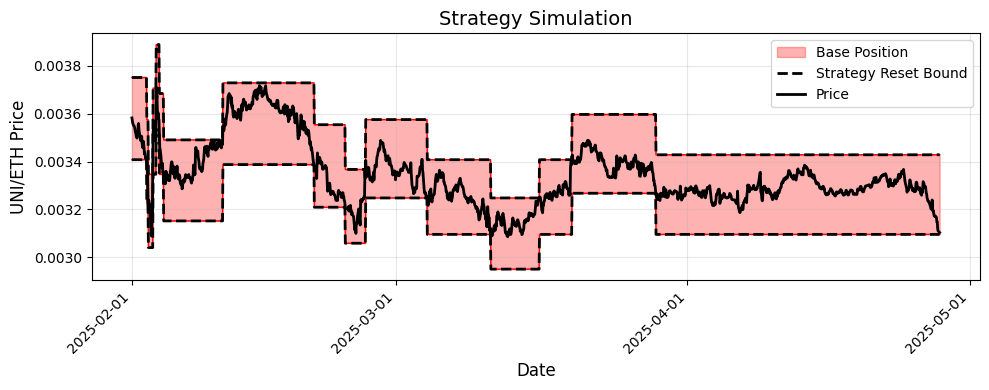

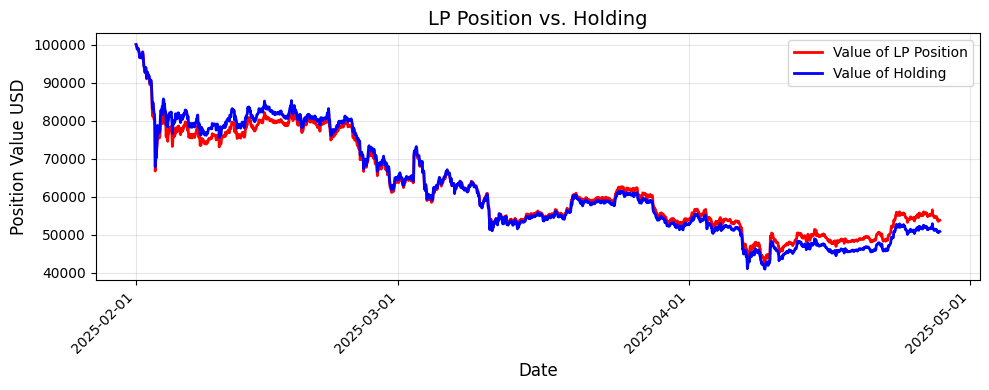

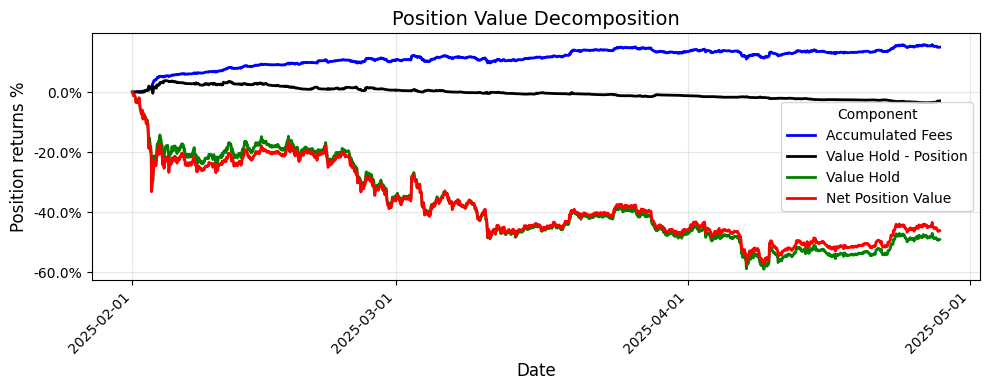

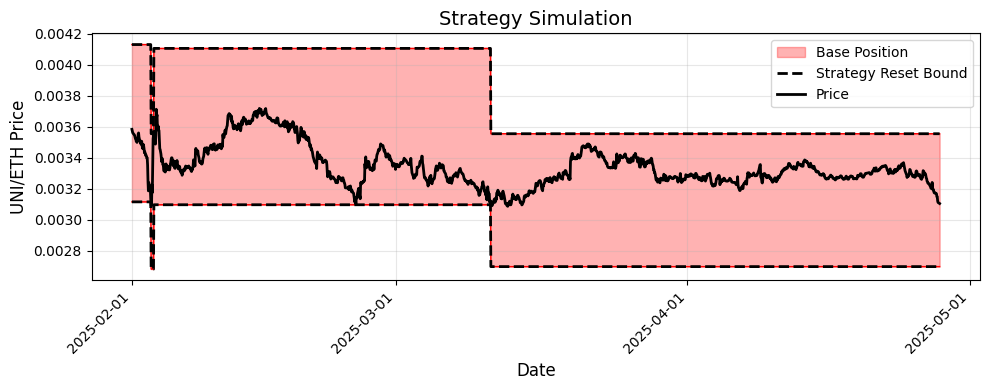

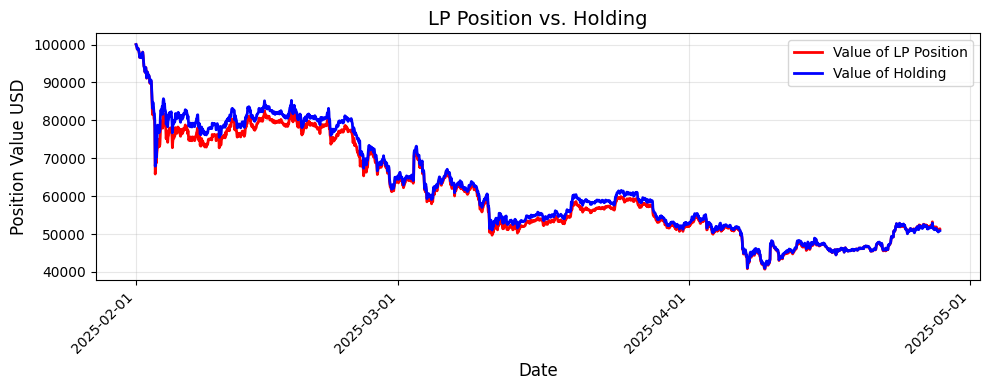

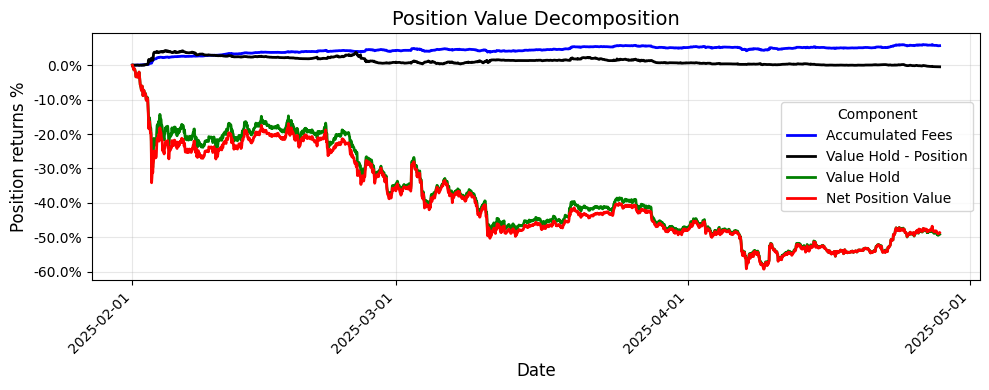

In [8]:

for i in range(len(sim_data_collect)):
    results = sim_data_collect[i]
    results.to_csv(f'strategy_results_{i}.csv')
    
    plot_strategy(results,'UNI/ETH Price')
    plot_position_value(results)
    plot_position_return_decomposition(results)
    


In [14]:
# Load strategy results
try:
    results_df = pd.read_csv('strategy_results_0.csv', parse_dates=['time_pd'])
    results_df['time_pd'] = pd.to_datetime(results_df['time_pd'], utc=True)
    results_df.set_index('time_pd', inplace=True)
except FileNotFoundError:
    print("Error: strategy_results.csv not found")
    exit(1)
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit(1)

# Extract and print first and last timestamps
if not results_df.empty:
    first_timestamp = results_df.index.min()
    last_timestamp = results_df.index.max()
    print(f"First Timestamp: {first_timestamp}")
    print(f"Last Timestamp: {last_timestamp}")
else:
    print("Error: DataFrame is empty")

First Timestamp: 2025-02-01 00:00:00+00:00
Last Timestamp: 2025-04-27 19:00:00+00:00


In [15]:
# Cell 1: Import dependencies and fetch Bitget futures data
import pandas as pd
import ccxt
import time
from datetime import datetime
import os
import plotly.graph_objects as go

# Configuration
SYMBOLS = ['UNI/USDT:USDT', 'ETH/USDT:USDT']  # Bitget perpetual futures
TIMEFRAME = '1h'  # 1-hour candles
OUTPUT_DIR = 'bitget_futures_data'
LIMIT = 1000  # Max candles per request
FEE_RATE = 0.0002  # Bitget maker fee: 0.02%

# Initialize Bitget exchange
exchange = ccxt.bitget({'enableRateLimit': True})

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def milliseconds_to_datetime(ms):
    """Convert milliseconds to datetime."""
    return datetime.utcfromtimestamp(ms / 1000)

def fetch_ohlcv_data(symbol, timeframe, since, limit):
    """Fetch OHLCV data for a symbol."""
    all_ohlcv = []
    while True:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 1
            print(f"Fetched {len(ohlcv)} OHLCV candles for {symbol} from {milliseconds_to_datetime(since)}")
            time.sleep(0.5)
        except Exception as e:
            print(f"Error fetching OHLCV for {symbol}: {e}")
            time.sleep(5)
            continue
    return all_ohlcv

def save_ohlcv_to_csv(symbol, ohlcv_data):
    """Save OHLCV data to CSV."""
    if not ohlcv_data:
        print(f"No OHLCV data to save for {symbol}")
        return
    df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    symbol_clean = symbol.replace('/', '_').replace(':', '_')
    df.to_csv(f"{OUTPUT_DIR}/{symbol_clean}_ohlcv.csv", index=False)
    print(f"Saved OHLCV data for {symbol} to {OUTPUT_DIR}/{symbol_clean}_ohlcv.csv")

# Load strategy results
results_df = pd.read_csv('strategy_results_0.csv', parse_dates=['time_pd'])
results_df['time_pd'] = pd.to_datetime(results_df['time_pd'], utc=True)
results_df.set_index('time_pd', inplace=True)

# Fetch futures data
start_time = results_df.index[0]
end_time = results_df.index[-1]
since = int(start_time.timestamp() * 1000)

for symbol in SYMBOLS:
    ohlcv_data = fetch_ohlcv_data(symbol, TIMEFRAME, since, LIMIT)
    save_ohlcv_to_csv(symbol, ohlcv_data)

Fetched 200 OHLCV candles for UNI/USDT:USDT from 2025-03-14 15:00:00.001000
Fetched 200 OHLCV candles for UNI/USDT:USDT from 2025-04-25 06:00:00.001000
Fetched 200 OHLCV candles for UNI/USDT:USDT from 2025-06-05 21:00:00.001000
Fetched 1000 OHLCV candles for UNI/USDT:USDT from 2025-07-17 13:00:00.001000
Fetched 3 OHLCV candles for UNI/USDT:USDT from 2025-07-17 16:00:00.001000
Saved OHLCV data for UNI/USDT:USDT to bitget_futures_data/UNI_USDT_USDT_ohlcv.csv
Fetched 200 OHLCV candles for ETH/USDT:USDT from 2025-03-14 15:00:00.001000
Fetched 200 OHLCV candles for ETH/USDT:USDT from 2025-04-25 06:00:00.001000
Fetched 200 OHLCV candles for ETH/USDT:USDT from 2025-06-05 21:00:00.001000
Fetched 1000 OHLCV candles for ETH/USDT:USDT from 2025-07-17 13:00:00.001000
Fetched 3 OHLCV candles for ETH/USDT:USDT from 2025-07-17 16:00:00.001000
Saved OHLCV data for ETH/USDT:USDT to bitget_futures_data/ETH_USDT_USDT_ohlcv.csv


In [16]:
import pandas as pd
import plotly.graph_objects as go

# Load strategy results
try:
    results_df = pd.read_csv('strategy_results_0.csv', parse_dates=['time_pd'])
    results_df['time_pd'] = pd.to_datetime(results_df['time_pd'], utc=True)
    results_df.set_index('time_pd', inplace=True)
except FileNotFoundError:
    print("Error: strategy_results.csv not found")
    exit(1)
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit(1)

# Debug: Verify strategy results
print("Strategy Results Shape:", results_df.shape)
print("Columns:", results_df.columns.tolist())
print("First Timestamp:", results_df.index.min())
print("Last Timestamp:", results_df.index.max())
print("Time Window Duration:", results_df.index.max() - results_df.index.min())
print("Number of Reset Points:", results_df['reset_point'].sum())
if results_df['reset_point'].sum() > 0:
    print("Reset Point Timestamps:", results_df[results_df['reset_point']].index.tolist())

# Verify required columns
required_columns = ['reset_point', 'token_0_total', 'token_1_total', 'price', 'price_0_usd', 'value_position_usd', 'value_hold_usd']
if not all(col in results_df.columns for col in required_columns):
    print(f"Error: Missing required columns. Found: {results_df.columns.tolist()}")
    exit(1)

# Load Bitget futures data
try:
    uni_futures = pd.read_csv('bitget_futures_data/UNI_USDT_USDT_ohlcv.csv', parse_dates=['datetime'])
    eth_futures = pd.read_csv('bitget_futures_data/ETH_USDT_USDT_ohlcv.csv', parse_dates=['datetime'])
    uni_futures['datetime'] = pd.to_datetime(uni_futures['datetime'], utc=True)
    eth_futures['datetime'] = pd.to_datetime(eth_futures['datetime'], utc=True)
except FileNotFoundError:
    print("Error: Bitget futures data files not found in bitget_futures_data/")
    exit(1)
except Exception as e:
    print(f"Error loading Bitget futures data: {e}")
    exit(1)

# Resample futures data to hourly
uni_futures = uni_futures.set_index('datetime').resample('H').ffill()['close'].rename('uni_futures_price').to_frame()
eth_futures = eth_futures.set_index('datetime').resample('H').ffill()['close'].rename('weth_futures_price').to_frame()

# Debug: Verify futures data
print("\nUNI Futures Shape:", uni_futures.shape)
print("UNI Futures Columns:", uni_futures.columns.tolist())
print("UNI First Timestamp:", uni_futures.index.min())
print("UNI Last Timestamp:", uni_futures.index.max())
print("ETH Futures Shape:", eth_futures.shape)
print("ETH Futures Columns:", eth_futures.columns.tolist())
print("ETH First Timestamp:", eth_futures.index.min())
print("ETH Last Timestamp:", eth_futures.index.max())

# Merge futures prices using merge_asof with wider tolerance
results_df = pd.merge_asof(
    results_df.reset_index(),
    uni_futures.reset_index(),
    left_on='time_pd',
    right_on='datetime',
    direction='backward',  # Use previous price to avoid future bias
    tolerance=pd.Timedelta('2H')
).set_index('time_pd')
results_df = pd.merge_asof(
    results_df.reset_index(),
    eth_futures.reset_index(),
    left_on='time_pd',
    right_on='datetime',
    direction='backward',
    tolerance=pd.Timedelta('2H')
).set_index('time_pd')

results_df.to_csv('strategy_results_with_futures.csv')


# Debug: Check for NaN in futures prices
print("\nNaN in Futures Prices:")
print("UNI Futures Price NaN Count:", results_df['uni_futures_price'].isna().sum())
print("WETH Futures Price NaN Count:", results_df['weth_futures_price'].isna().sum())
print("Sample Data with NaN (first 5 rows with NaN):")
print(results_df[results_df['uni_futures_price'].isna() | results_df['weth_futures_price'].isna()][['uni_futures_price', 'weth_futures_price']].head())

# Backfill NaN futures prices with earliest available price
if results_df['uni_futures_price'].isna().any():
    earliest_uni_price = uni_futures['uni_futures_price'].iloc[0]
    results_df['uni_futures_price'] = results_df['uni_futures_price'].fillna(earliest_uni_price)
    print(f"\nBackfilled UNI futures NaNs with earliest price: ${earliest_uni_price:.2f}")
if results_df['weth_futures_price'].isna().any():
    earliest_weth_price = eth_futures['weth_futures_price'].iloc[0]
    results_df['weth_futures_price'] = results_df['weth_futures_price'].fillna(earliest_weth_price)
    print(f"Backfilled WETH futures NaNs with earliest price: ${earliest_weth_price:.2f}")


Strategy Results Shape: (2057, 37)
Columns: ['Unnamed: 0', 'time', 'price', 'reset_point', 'compound_point', 'reset_reason', 'base_range_lower', 'base_range_upper', 'limit_range_lower', 'limit_range_upper', 'reset_range_lower', 'reset_range_upper', 'price_at_reset', 'token_0_fees', 'token_1_fees', 'token_0_fees_uncollected', 'token_1_fees_uncollected', 'token_0_left_over', 'token_1_left_over', 'token_0_allocated', 'token_1_allocated', 'token_0_total', 'token_1_total', 'value_position_in_token_0', 'value_allocated_in_token_0', 'value_left_over_in_token_0', 'base_position_value_in_token_0', 'limit_position_value_in_token_0', 'price_0_usd', 'value_position_usd', 'base_position_value_usd', 'limit_position_value_usd', 'cum_fees_0', 'cum_fees_usd', 'token_0_hold_usd', 'token_1_hold_usd', 'value_hold_usd']
First Timestamp: 2025-02-01 00:00:00+00:00
Last Timestamp: 2025-04-27 19:00:00+00:00
Time Window Duration: 85 days 19:00:00
Number of Reset Points: 15
Reset Point Timestamps: [Timestamp('20

C:\Users\Z640\AppData\Local\Temp\ipykernel_14792\548188771.py:46: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\Z640\AppData\Local\Temp\ipykernel_14792\548188771.py:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\Z640\AppData\Local\Temp\ipykernel_14792\548188771.py:66: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

C:\Users\Z640\AppData\Local\Temp\ipykernel_14792\548188771.py:74: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.



In [17]:

# Initialize PnL columns
initial_value_position = results_df.iloc[0]['value_position_usd']
initial_value_hold = results_df.iloc[0]['value_hold_usd']
results_df['lp_pnl_usd'] = results_df['value_position_usd'] - initial_value_position
results_df['hold_pnl_usd'] = results_df['value_hold_usd'] - initial_value_hold
results_df['uni_hedge_qty'] = 0.0
results_df['weth_hedge_qty'] = 0.0
results_df['uni_hedge_entry_price'] = 0.0
results_df['weth_hedge_entry_price'] = 0.0
results_df['hedge_realized_pnl_usd'] = 0.0
results_df['hedge_unrealized_pnl_usd'] = 0.0
results_df['hedge_total_pnl_usd'] = 0.0
results_df['combined_pnl_usd'] = results_df['lp_pnl_usd']

# Bitget maker fee
FEE_RATE = 0.0002

# Initialize first hedge
if not results_df.empty:
    results_df.iloc[0, results_df.columns.get_loc('uni_hedge_qty')] = -results_df.iloc[0]['token_0_total']
    results_df.iloc[0, results_df.columns.get_loc('weth_hedge_qty')] = -results_df.iloc[0]['token_1_total']
    results_df.iloc[0, results_df.columns.get_loc('uni_hedge_entry_price')] = results_df.iloc[0]['uni_futures_price']
    results_df.iloc[0, results_df.columns.get_loc('weth_hedge_entry_price')] = results_df.iloc[0]['weth_futures_price']
    print("\nInitial Hedge:")
    print(f"UNI Hedge Qty: {results_df.iloc[0]['uni_hedge_qty']:.2f}")
    print(f"WETH Hedge Qty: {results_df.iloc[0]['weth_hedge_qty']:.2f}")
    print(f"UNI Mean Acquisition Price: ${results_df.iloc[0]['uni_hedge_entry_price']:.2f}")
    print(f"WETH Mean Acquisition Price: ${results_df.iloc[0]['weth_hedge_entry_price']:.2f}")

# Process hedging and PnL
for i in range(1, len(results_df)):
    # Carry forward hedge positions
    results_df.iloc[i, results_df.columns.get_loc('uni_hedge_qty')] = results_df.iloc[i-1]['uni_hedge_qty']
    results_df.iloc[i, results_df.columns.get_loc('weth_hedge_qty')] = results_df.iloc[i-1]['weth_hedge_qty']
    results_df.iloc[i, results_df.columns.get_loc('uni_hedge_entry_price')] = results_df.iloc[i-1]['uni_hedge_entry_price']
    results_df.iloc[i, results_df.columns.get_loc('weth_hedge_entry_price')] = results_df.iloc[i-1]['weth_hedge_entry_price']
    results_df.iloc[i, results_df.columns.get_loc('hedge_realized_pnl_usd')] = results_df.iloc[i-1]['hedge_realized_pnl_usd']
    

    # Check for rebalance
    if results_df.iloc[i]['reset_point']:
        # Current quantities (negative for shorts)
        old_uni_qty = results_df.iloc[i-1]['uni_hedge_qty']
        old_weth_qty = results_df.iloc[i-1]['weth_hedge_qty']
        new_uni_qty = -results_df.iloc[i]['token_0_total']
        new_weth_qty = -results_df.iloc[i]['token_1_total']
        
        # Calculate quantity to close (positive if reducing short, negative if increasing)
        uni_qty_to_close = -(old_uni_qty - new_uni_qty)  # Positive if buying back
        weth_qty_to_close = -(old_weth_qty - new_weth_qty)
        
        total_realized_pnl = 0
        uni_fee = 0
        weth_fee = 0
        uni_fee_open = 0
        weth_fee_open = 0
        uni_pnl_realized = 0
        weth_pnl_realized = 0

        # Realized PnL and fees for UNI
        if uni_qty_to_close != 0:
            if uni_qty_to_close > 0:  # Reducing short (buying back)
                uni_pnl_realized = abs(uni_qty_to_close) * (results_df.iloc[i-1]['uni_hedge_entry_price'] - results_df.iloc[i]['uni_futures_price'])
                uni_fee = abs(uni_qty_to_close * results_df.iloc[i]['uni_futures_price'] * FEE_RATE)
                total_realized_pnl += uni_pnl_realized - uni_fee
            uni_fee_open = abs(uni_qty_to_close * results_df.iloc[i]['uni_futures_price'] * FEE_RATE)

        # Realized PnL and fees for WETH
        if weth_qty_to_close != 0:
            if weth_qty_to_close > 0:  # Reducing short
                weth_pnl_realized = abs(weth_qty_to_close) * (results_df.iloc[i-1]['weth_hedge_entry_price'] - results_df.iloc[i]['weth_futures_price'])
                weth_fee = abs(weth_qty_to_close * results_df.iloc[i]['weth_futures_price'] * FEE_RATE)
                total_realized_pnl += weth_pnl_realized - weth_fee
            weth_fee_open = abs(weth_qty_to_close * results_df.iloc[i]['weth_futures_price'] * FEE_RATE)

        # Update realized PnL
        results_df.iloc[i, results_df.columns.get_loc('hedge_realized_pnl_usd')] = (
            results_df.iloc[i-1]['hedge_realized_pnl_usd'] + total_realized_pnl
        )
        
        # Update hedge quantities
        results_df.iloc[i, results_df.columns.get_loc('uni_hedge_qty')] = new_uni_qty
        results_df.iloc[i, results_df.columns.get_loc('weth_hedge_qty')] = new_weth_qty

        # Update mean acquisition price (only if increasing short)
        if uni_qty_to_close < 0:  # Increasing short (selling more)
            
            results_df.iloc[i, results_df.columns.get_loc('uni_hedge_entry_price')] = (
                (abs(old_uni_qty) * results_df.iloc[i-1]['uni_hedge_entry_price'] + abs(uni_qty_to_close) * results_df.iloc[i]['uni_futures_price']) /
                (abs(uni_qty_to_close) + abs(old_uni_qty))
            )
        else:
            results_df.iloc[i, results_df.columns.get_loc('uni_hedge_entry_price')] = results_df.iloc[i-1]['uni_hedge_entry_price']
        
        if weth_qty_to_close < 0:  # Increasing short
            results_df.iloc[i, results_df.columns.get_loc('weth_hedge_entry_price')] = (
                (abs(old_weth_qty) * results_df.iloc[i-1]['weth_hedge_entry_price'] + abs(weth_qty_to_close) * results_df.iloc[i]['weth_futures_price']) /
                (abs(weth_qty_to_close) + abs(old_weth_qty))
            )
        else:
            results_df.iloc[i, results_df.columns.get_loc('weth_hedge_entry_price')] = results_df.iloc[i-1]['weth_hedge_entry_price']

        print(f"\nRebalance at {results_df.index[i]}:")
        print(f"Realized PnL: ${total_realized_pnl:.2f} (UNI: ${uni_pnl_realized:.2f}, WETH: ${weth_pnl_realized:.2f}, Close Fees: ${uni_fee + weth_fee:.2f}, Open Fees: ${uni_fee_open + weth_fee_open:.2f})")
        print(f"New UNI Hedge Qty: {new_uni_qty:.2f}, New Mean Acquisition Price: ${results_df.iloc[i]['uni_hedge_entry_price']:.2f}")
        print(f"New WETH Hedge Qty: {new_weth_qty:.2f}, New Mean Acquisition Price: ${results_df.iloc[i]['weth_hedge_entry_price']:.2f}")


    # Calculate unrealized PnL (short position: profit when price drops)
    uni_unrealized = results_df.iloc[i]['uni_hedge_qty'] * (results_df.iloc[i]['uni_futures_price'] - results_df.iloc[i]['uni_hedge_entry_price'] )
    weth_unrealized = results_df.iloc[i]['weth_hedge_qty'] * (results_df.iloc[i]['weth_futures_price'] - results_df.iloc[i]['weth_hedge_entry_price'])
    results_df.iloc[i, results_df.columns.get_loc('hedge_unrealized_pnl_usd')] = uni_unrealized + weth_unrealized

    

    # Update total hedge PnL
    results_df.iloc[i, results_df.columns.get_loc('hedge_total_pnl_usd')] = (
        results_df.iloc[i]['hedge_realized_pnl_usd'] + results_df.iloc[i]['hedge_unrealized_pnl_usd']
    )
    
    # Update combined PnL
    results_df.iloc[i, results_df.columns.get_loc('combined_pnl_usd')] = (
        results_df.iloc[i]['lp_pnl_usd'] + results_df.iloc[i]['hedge_total_pnl_usd']
    )

# Debug: Check for NaN in mean acquisition prices
print("\nNaN in Mean Acquisition Prices:")
print("UNI Hedge Entry Price NaN Count:", results_df['uni_hedge_entry_price'].isna().sum())
print("WETH Hedge Entry Price NaN Count:", results_df['weth_hedge_entry_price'].isna().sum())

# Save results
results_df.to_csv('strategy_results_hedged_pnl.csv')



Initial Hedge:
UNI Hedge Qty: -4207.11
WETH Hedge Qty: -15.07
UNI Mean Acquisition Price: $7.52
WETH Mean Acquisition Price: $2292.25

Rebalance at 2025-02-02 14:00:00+00:00:
Realized PnL: $-0.24 (UNI: $0.00, WETH: $0.00, Close Fees: $0.24, Open Fees: $0.35)
New UNI Hedge Qty: -4284.55, New Mean Acquisition Price: $7.52
New WETH Hedge Qty: -14.55, New Mean Acquisition Price: $2292.25

Rebalance at 2025-02-02 18:00:00+00:00:
Realized PnL: $-0.30 (UNI: $0.00, WETH: $0.00, Close Fees: $0.30, Open Fees: $0.42)
New UNI Hedge Qty: -4361.78, New Mean Acquisition Price: $7.52
New WETH Hedge Qty: -13.89, New Mean Acquisition Price: $2292.25

Rebalance at 2025-02-03 06:00:00+00:00:
Realized PnL: $-0.34 (UNI: $0.00, WETH: $0.00, Close Fees: $0.34, Open Fees: $0.65)
New UNI Hedge Qty: -4138.35, New Mean Acquisition Price: $7.52
New WETH Hedge Qty: -14.57, New Mean Acquisition Price: $2292.25

Rebalance at 2025-02-03 14:00:00+00:00:
Realized PnL: $-0.19 (UNI: $0.00, WETH: $0.00, Close Fees: $0.19,

In [18]:

# Plot PnL
def plot_pnl(data_strategy):
    CHART_SIZE = 300
    required_columns = ['lp_pnl_usd', 'hold_pnl_usd', 'hedge_total_pnl_usd', 'combined_pnl_usd']
    if not all(col in data_strategy.columns for col in required_columns):
        print("Error: Missing required columns in data_strategy")
        return None

    print("\ntime_pd dtype:", data_strategy.index.dtype)
    print("time_pd head:", data_strategy.index[:5].tolist())

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=data_strategy.index,
        y=data_strategy['lp_pnl_usd'],
        name='LP PnL',
        line=dict(width=2, color='red')
    ))
    fig.add_trace(go.Scatter(
        x=data_strategy.index,
        y=data_strategy['hold_pnl_usd'],
        name='Hold PnL',
        line=dict(width=2, color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=data_strategy.index,
        y=data_strategy['hedge_total_pnl_usd'],
        name='Hedge Total PnL',
        line=dict(width=2, color='green')
    ))
    fig.add_trace(go.Scatter(
        x=data_strategy.index,
        y=data_strategy['combined_pnl_usd'],
        name='Combined PnL (LP + Hedge)',
        line=dict(width=2, color='purple')
    ))

    fig.update_layout(
        margin=dict(l=20, r=20, t=40, b=20),
        height=CHART_SIZE,
        title='PnL Analysis: LP vs. Hold vs. Hedge vs. Combined',
        xaxis_title="Date",
        yaxis_title='PnL (USD)',
        xaxis_type='date',
        xaxis=dict(tickformat='%Y-%m-%d', tickmode='auto')
    )

    fig.show()
    return fig

# Plot results
plot_pnl(results_df)
results_df.to_csv('strategy_results_hedged_pnl.csv')
# Print final PnL summary
print("\nFinal PnL Summary:")
print(f"LP PnL: ${results_df.iloc[-1]['lp_pnl_usd']:.2f}")
print(f"Hold PnL: ${results_df.iloc[-1]['hold_pnl_usd']:.2f}")
print(f"Hedge Realized PnL: ${results_df.iloc[-1]['hedge_realized_pnl_usd']:.2f}")
print(f"Hedge Unrealized PnL: ${results_df.iloc[-1]['hedge_unrealized_pnl_usd']:.2f}")
print(f"Hedge Total PnL: ${results_df.iloc[-1]['hedge_total_pnl_usd']:.2f}")
print(f"Combined PnL (LP + Hedge): ${results_df.iloc[-1]['combined_pnl_usd']:.2f}")


time_pd dtype: datetime64[ns, UTC]
time_pd head: [Timestamp('2025-02-01 00:00:00+0000', tz='UTC'), Timestamp('2025-02-01 01:00:00+0000', tz='UTC'), Timestamp('2025-02-01 02:00:00+0000', tz='UTC'), Timestamp('2025-02-01 03:00:00+0000', tz='UTC'), Timestamp('2025-02-01 04:00:00+0000', tz='UTC')]



Final PnL Summary:
LP PnL: $-46196.10
Hold PnL: $-49148.27
Hedge Realized PnL: $457.19
Hedge Unrealized PnL: $14139.64
Hedge Total PnL: $14596.83
Combined PnL (LP + Hedge): $-31599.27


In [19]:
results_df.to_csv('strategy_results_hedged_pnl.csv')